In [ ]:
! pip install --quiet "lightning"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.0/846.0 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 65.2 MB/s eta 0:00:00


In [ ]:
!gdown --quiet 1UL2FYpZmqvyFchFReFVJEi3V47F8ksv_

In [ ]:
!unzip -q /content/CIFAR-10-images-master.zip

In [ ]:
from glob import glob  # For file path matching and retrieval
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations on arrays
import os  # For operating system interface
import lightning.pytorch as L  # For PyTorch Lightning functionality
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping  # Model callbacks
from lightning.pytorch.callbacks import ModelSummary  # For summarizing model architecture
import torchmetrics  # For PyTorch metrics computation
import torch  # For PyTorch deep learning framework
from torch import nn  # For building neural network modules
import torchvision  # For computer vision utilities and datasets
from torchvision import transforms  # For data transformations
import torchvision.transforms.functional as F  # Functional transformations
import matplotlib.pyplot as plt  # For plotting graphs
from sklearn.model_selection import train_test_split  # For data splitting
import random  # For random number generation
import torch
from torchvision import transforms

def set_seed(seed: int = 0) -> None:
    """Set random seed for reproducibility across numpy, random, torch, and CUDA."""
    np.random.seed(seed)  # Seed for numpy operations
    random.seed(seed)  # Seed for random module
    torch.manual_seed(seed)  # Seed for PyTorch on CPU
    torch.cuda.manual_seed(seed)  # Seed for PyTorch on CUDA GPU

    # Ensure reproducibility on CuDNN backend
    torch.backends.cudnn.deterministic = True  # Disable nondeterministic algorithms
    torch.backends.cudnn.benchmark = False  # Disable performance optimizations for determinism

    # Set a fixed value for the hash seed for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")  # Confirm seed setting

# Set default seed for reproducibility
set_seed()

Random seed set as 0


In [ ]:
test_path = "/content/CIFAR-10-images-master/test/"  # Path to test dataset
train_path = "/content/CIFAR-10-images-master/train/"  # Path to training dataset

# List all file or directory names in the training path directory
list_ = [name for name in os.listdir(train_path)]
string2int = {name: index for index, name in enumerate(list_)}
def get_path(path):
    """Generate a list of dictionaries with image paths, labels, and class names for a given dataset path."""
    paths = []
    for name in list_:
        # Retrieve all .jpg files within each subdirectory under the given path
        l = glob(f"{path}{name}/*.jpg")

        # Append each image's path and its label (converted to int) to the paths list
        for i in l:
            paths.append({
                "name": name,
                "path": i,
                "label": string2int[name]
            })

    return paths

# Generate lists of paths with labels for both training and validation datasets
train_paths = get_path(train_path)
test_paths = get_path(test_path)
train_paths, val_paths = train_test_split(train_paths, test_size=0.2, random_state=0)

In [ ]:
class DataSet(torch.utils.data.Dataset):
    """Custom Dataset for loading images and their corresponding labels."""

    def __init__(self, features, transform=None):
        """Initialize the dataset with features and optional transformations.

        Args:
            features (list): List of dictionaries containing image paths and labels.
            transform (callable, optional): Optional transform to be applied on the images.
        """
        super(DataSet, self).__init__()
        self.features = features  # Store the list of features (paths and labels)
        self.transform = transform  # Store the transformation if provided

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """Retrieve an item from the dataset given an index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: A dictionary containing the image tensor and its corresponding label.
        """
        # Get the path of the image based on the index
        paths = self.features[idx]["path"]

        # Read the image from the path
        images = torchvision.io.read_image(paths)

        # Apply transformations if any
        if self.transform is not None:
            images = self.transform(images)

        # Retrieve the label for the current index
        label = torch.tensor(self.features[idx]["label"])

        return {"images": images, "labels": label}

# Instantiate the dataset
train_dataset = DataSet(train_paths)
test_dataset = DataSet(test_paths)
val_dataset = DataSet(val_paths)

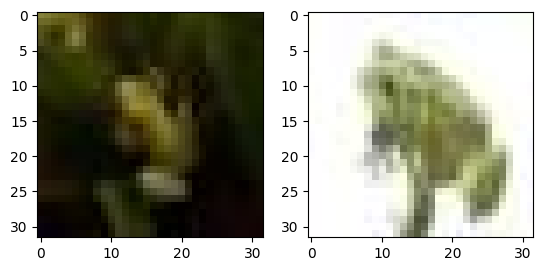

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F

def show(imgs):
    """
    Display a list of images in a single row.

    Parameters:
        imgs (list or single image): List of images or a single image tensor.
    """
    # Ensure imgs is a list for consistent processing
    if not isinstance(imgs, list):
        imgs = [imgs]

    # Create subplots with one column per image
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)

    # Iterate through images and display each one
    for i, img in enumerate(imgs):
        img = img.detach()  # Detach from computation graph (if tensor)
        img = F.to_pil_image(img)  # Convert tensor to PIL image
        axs[0, i].imshow(np.asarray(img))  # Display image in subplot

# Initialize an iterator for the test dataset
data_iter = iter(test_dataset)

# Display the first two images from the test dataset
show([next(data_iter)["images"], next(data_iter)["images"]])


In [ ]:

# Define batch size and number of workers for DataLoader
batch_size = 32
num_workers = 2

# Define transformations for training images
train_transforms = transforms.Compose([
    transforms.ToPILImage(),  # Convert image to PIL format
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),  # Adjust image color properties
    transforms.ToTensor(),  # Convert image to tensor format
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalize using ImageNet mean and std
])

# Define transformations for test/validation images
test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Initialize datasets with corresponding transformations
train_dataset = DataSet(train_paths, transform=train_transforms)
test_dataset = DataSet(test_paths, transform=test_transforms)
val_dataset = DataSet(val_paths, transform=test_transforms)

# Create DataLoaders for each dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)



    title ResNet-50 Architecture

    Conv & MaxPool : Input → Conv7×7 (112x112x64)→ MaxPool (56x56x64)

    Layer1 : Block1 (64→256, s1, downsample) → Block2 → Block3 (56x56x256)

    Layer2 : Block1 (256→512, s2, downsample) → Block2 → Block3 → Block4 (28x28x512)

    Layer3 : Block1 (512→1024, s2, downsample) → Block2–6 (14x14x1024)

    Layer4 : Block1 (1024→2048, s2, downsample) → Block2 → Block3 (7x7x2048)

    Output : AvgPool → FC


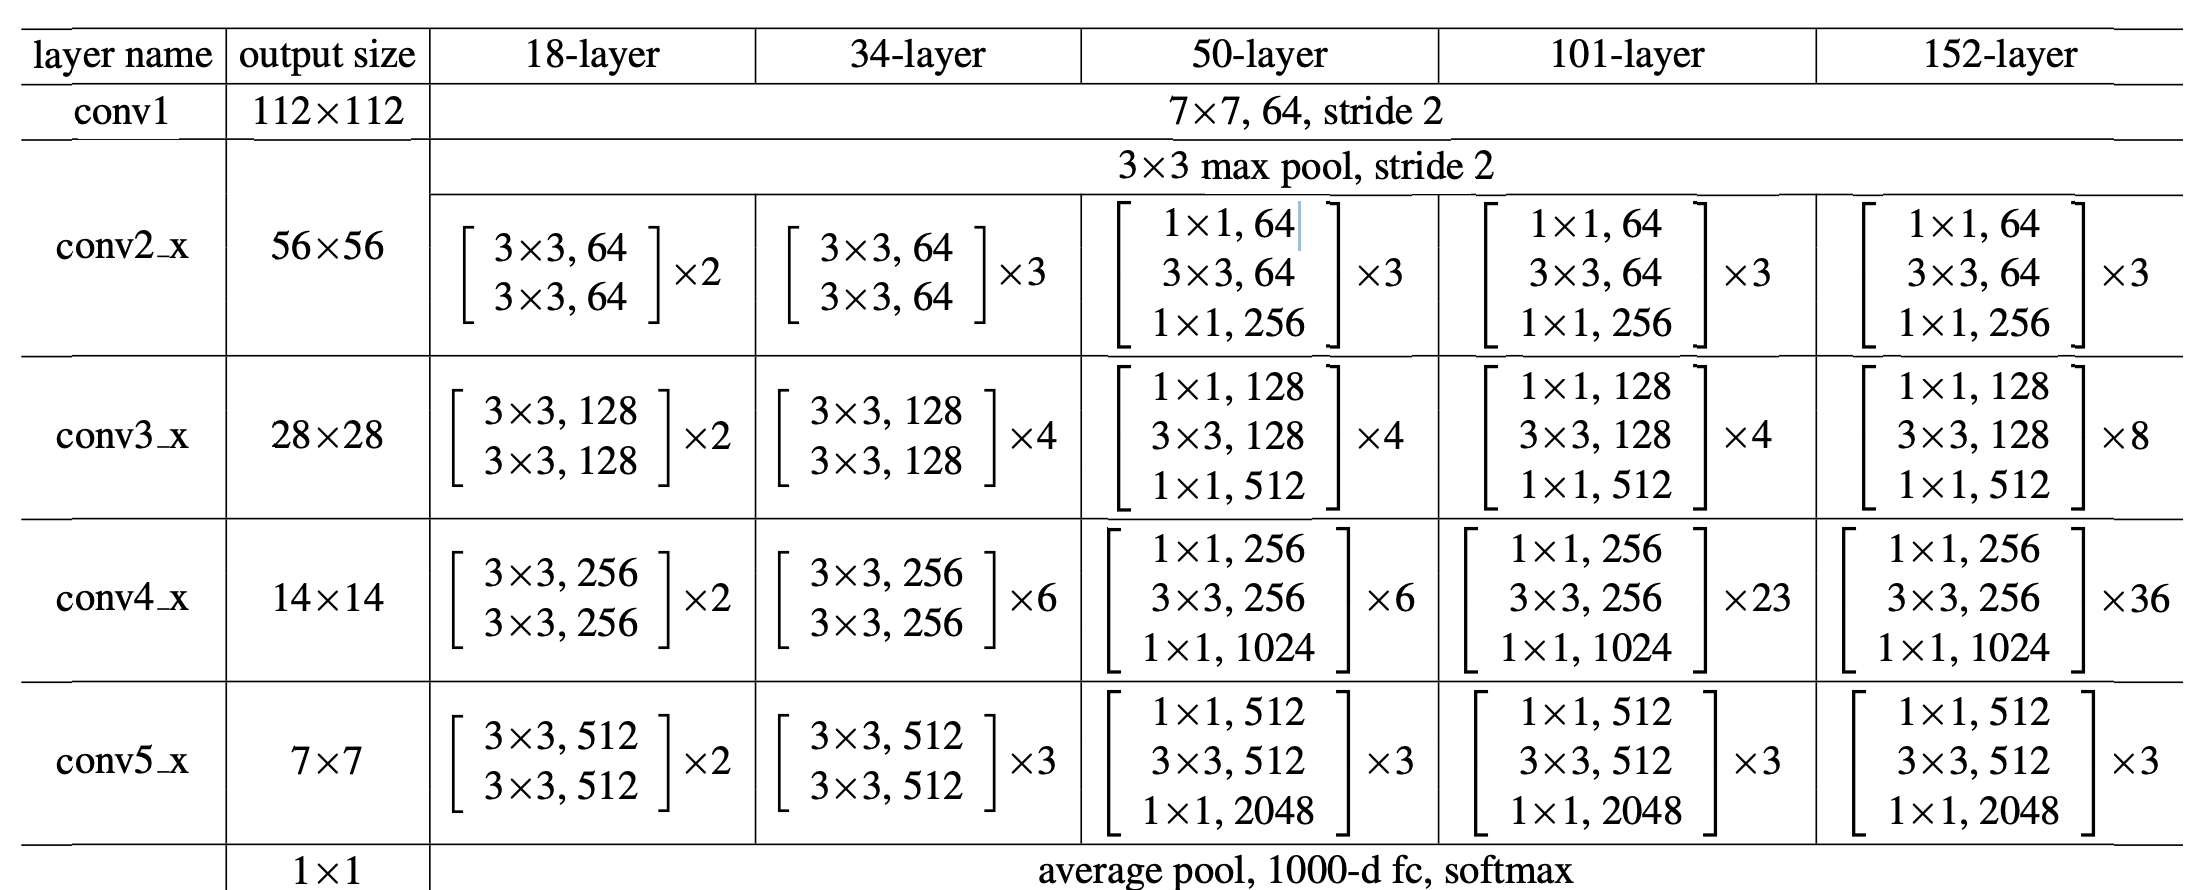

In [ ]:

# Define the Residual Block used in ResNet
class ResidualBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1, downsample=None):
        super().__init__()

        # Define the main convolutional block with three layers
        self.conv_block = nn.Sequential(
            # First layer: 1x1 convolution, reduces number of channels to c_out
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),

            # Second layer: 3x3 convolution, maintains channel size at c_out
            nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU(inplace=True),

            # Third layer: 1x1 convolution, expands channels to c_out * 4
            nn.Conv2d(c_out, c_out * 4, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(c_out * 4),
        )

        # Define downsampling layer if needed to match input/output dimensions
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Save the input as identity for the residual connection
        out = self.conv_block(x)  # Pass input through main convolutional block

        # If downsample layer is defined, apply it to the identity
        if self.downsample:
            identity = self.downsample(x)

        # Add the residual (identity) to the output of the conv block
        out += identity
        out = self.relu(out)  # Apply ReLU to the combined output
        return out


# Define the ResNet50 model as a PyTorch Lightning module
class ResNet50(L.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNet50, self).__init__()
        self.loss = torch.nn.CrossEntropyLoss()
        # Initial number of input channels
        self.in_channels = 64
        self.num_classes = num_classes

        # Initial layers before the main ResNet blocks
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define ResNet layers, each layer contains a certain number of blocks
        self.layer1 = self._make_layer(64, 3)  # Layer 1 with 3 blocks
        self.layer2 = self._make_layer(128, 4, stride=2)  # Layer 2 with 4 blocks
        self.layer3 = self._make_layer(256, 6, stride=2)  # Layer 3 with 6 blocks
        self.layer4 = self._make_layer(512, 3, stride=2)  # Layer 4 with 3 blocks

        # Pooling and fully connected layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, self.num_classes)  # Output layer for classification

    def _make_layer(self, out_channels, blocks, stride=1):
        # Define downsampling if stride != 1 or input and output channels differ
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        # Create the list of blocks, starting with the downsampling block if needed
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * 4  # Update in_channels for the next block

        # Add remaining blocks without downsampling
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))

        return nn.Sequential(*layers)  # Return the layer as a sequential block

    def forward(self, x):
        # Initial convolution and pooling layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through each ResNet layer
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Pool and flatten for fully connected layer
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'loss': loss, 'acc': accuracy}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        val_loss = self.loss(y_hat, y)
        val_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'val_loss': val_loss, 'val_acc': val_accuracy}, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['images'], batch['labels']
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        test_accuracy = (y_hat.argmax(dim=1) == y).float().mean()
        self.log_dict({'test_loss': test_loss, 'test_acc': test_accuracy}, prog_bar=True)
        return test_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, _ = batch['images'], batch['labels']
        y_hat = self(x)
        probabilities = torch.softmax(y_hat, dim=1)
        predicted_labels = torch.argmax(probabilities, dim=1)
        return {"y_pred": predicted_labels}

    def configure_optimizers(self):
        # Define optimizer (Adam) with a specified learning rate
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model = ResNet50()
trainer = L.Trainer(max_epochs=2, detect_anomaly=True, callbacks=callbacks)

trainer.fit(model, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Output()

INFO: Epoch 0, global step 1250: 'val_acc' reached 0.43020 (best 0.43020), saving model to '/content/checkpoint/epoch=0-step=1250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 1250: 'val_acc' reached 0.43020 (best 0.43020), saving model to '/content/checkpoint/epoch=0-step=1250.ckpt' as top 1
INFO: Epoch 1, global step 2500: 'val_acc' reached 0.57760 (best 0.57760), saving model to '/content/checkpoint/epoch=1-step=2500.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 2500: 'val_acc' reached 0.57760 (best 0.57760), saving model to '/content/checkpoint/epoch=1-step=2500.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [ ]:
trainer.test(model, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5647000074386597     │
│         test_loss         │    1.1773895025253296     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.1773895025253296, 'test_acc': 0.5647000074386597}]

#Bài tập
1. Code lại mạng resnet -101
2. Train resnet - 101 với số epochs là 6, thay đổi batchsize để dùng hết 16gb vram đã train được đánh giá kết quả trên tập test
3. Thay BatchNorm ra sau activation function và so sánh kết quả với trước model ở 2.
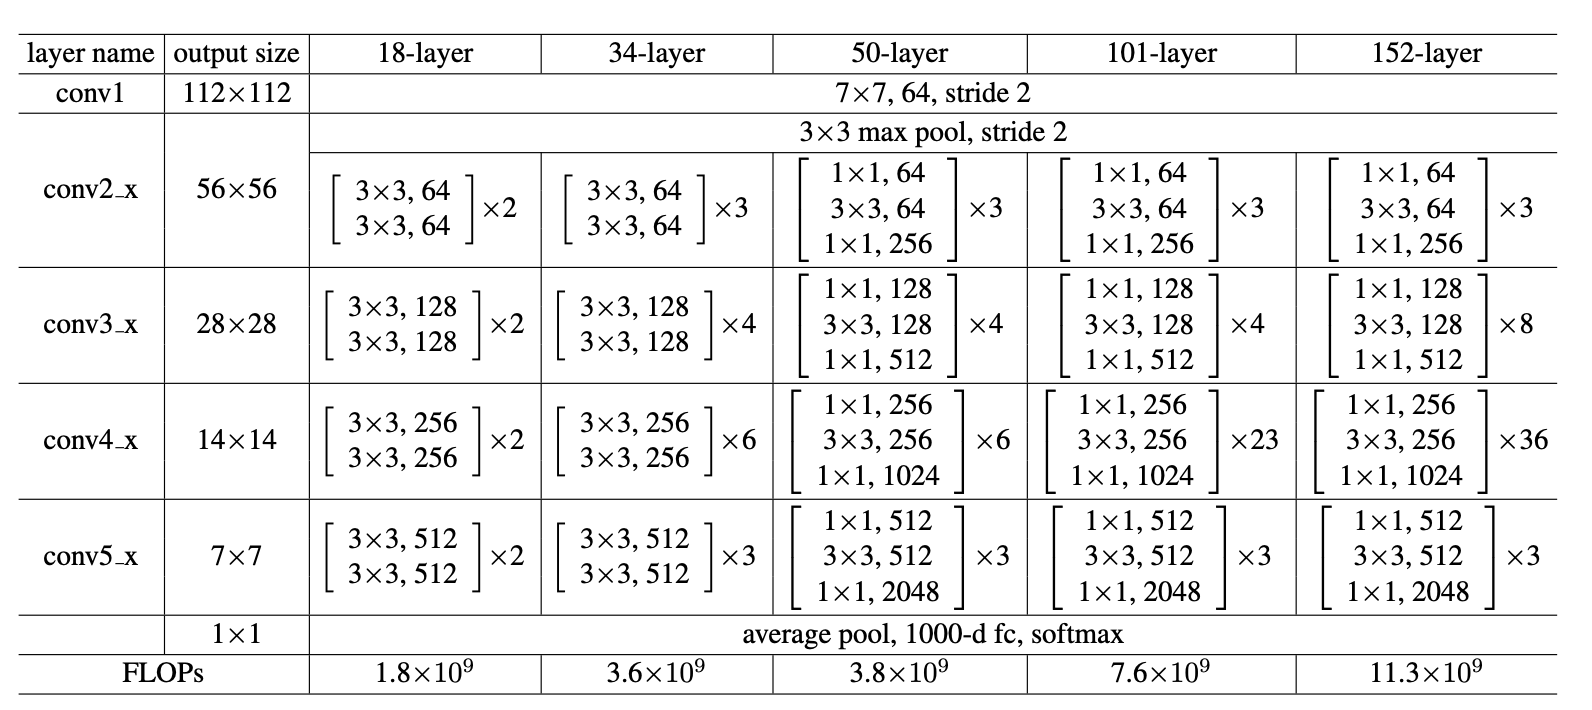

In [ ]:
class ResNet101(ResNet50):
    """
    Kế thừa kiến trúc của ResNet 50, thay layer 3 từ 6 block -> 23 block
    """
    def __init__(self, num_classes=10):

        super(ResNet101, self).__init__(num_classes=num_classes)
        self.loss = torch.nn.CrossEntropyLoss()
        # Initial number of input channels
        self.in_channels = 64
        self.num_classes = num_classes

        # Initial layers
        # conv1: 7 x 7, 64, stride 2
        # max pool: 3 x 3, stride 2

        # Define ResNet layers
        self.layer1 = self._make_layer(64, 3)
        self.layer2 = self._make_layer(128, 4, stride=2)
        self.layer3 = self._make_layer(256, 23, stride=2) # <-- main change
        self.layer4 = self._make_layer(512, 3, stride=2)

        # Pooling and fully connected layer for classification
        # average pool, 1000-d FC, softmax

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [ ]:
# Thiết lập lại batch size
batch_size = 64
num_workers = 2

# dataloader với batch size mới
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_ResNet101 = ResNet101()
trainer = L.Trainer(max_epochs=6, detect_anomaly=True, callbacks=callbacks) # Epochs = 6

trainer.fit(model_ResNet101, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Output()

INFO: Epoch 0, global step 625: 'val_acc' reached 0.39320 (best 0.39320), saving model to '/content/checkpoint/epoch=0-step=625.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 625: 'val_acc' reached 0.39320 (best 0.39320), saving model to '/content/checkpoint/epoch=0-step=625.ckpt' as top 1
INFO: Epoch 1, global step 1250: 'val_acc' reached 0.53850 (best 0.53850), saving model to '/content/checkpoint/epoch=1-step=1250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1250: 'val_acc' reached 0.53850 (best 0.53850), saving model to '/content/checkpoint/epoch=1-step=1250.ckpt' as top 1
INFO: Epoch 2, global step 1875: 'val_acc' reached 0.64160 (best 0.64160), saving model to '/content/checkpoint/epoch=2-step=1875.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1875: 'val_acc' reached 0.64160 (best 0.64160), saving model to '/content/checkpoint/epoch=2-step=1875.ckpt' as top 1
INFO: Epoch 3, global s

In [ ]:
trainer.test(model_ResNet101, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7311999797821045     │
│         test_loss         │    0.8384405374526978     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8384405374526978, 'test_acc': 0.7311999797821045}]

In [ ]:
# Define the New Residual Block used in ResNet
class AlteredResidualBlock(nn.Module):
    """
    Residual Block nhưng đảo thứ tự batch norm ra sau activation function
    """

    def __init__(self, c_in, c_out, stride=1, downsample=None):
        super().__init__()

        # Define the main convolutional block with three layers
        self.conv_block = nn.Sequential(
            # First layer: 1x1 convolution, reduces number of channels to c_out
            nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out),

            # Second layer: 3x3 convolution, maintains channel size at c_out
            nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(c_out),

            # Third layer: 1x1 convolution, expands channels to c_out * 4
            nn.Conv2d(c_out, c_out * 4, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(c_out * 4),
        )

        # Define downsampling layer if needed to match input/output dimensions
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x  # Save the input as identity for the residual connection
        out = self.conv_block(x)  # Pass input through main convolutional block

        # If downsample layer is defined, apply it to the identity
        if self.downsample:
            identity = self.downsample(x)

        # Add the residual (identity) to the output of the conv block
        out += identity
        out = self.relu(out)  # Apply ReLU to the combined output
        return out


In [ ]:
class AlteredResNet101(ResNet101):
    """
    Mạng ResNet 101 với Residual Block mới
    """

    def _make_layer(self, out_channels, blocks, stride=1):
        # Define downsampling if stride != 1 or input and output channels differ
        downsample = None
        if stride != 1 or self.in_channels != out_channels * 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * 4),
            )

        # Create the list of blocks, starting with the downsampling block if needed
        layers = []
        layers.append(AlteredResidualBlock(self.in_channels, out_channels, stride, downsample)) # <-- main change
        self.in_channels = out_channels * 4  # Update in_channels for the next block

        # Add remaining blocks without downsampling
        for _ in range(1, blocks):
            layers.append(AlteredResidualBlock(self.in_channels, out_channels)) # <-- main change

        return nn.Sequential(*layers)  # Return the layer as a sequential block

In [ ]:
model_checkpoint = ModelCheckpoint(dirpath='checkpoint/',
                                   monitor="val_acc",
                                   verbose=True,
                                   mode="max",
                                   save_top_k=1
                                   )
early_stopping = EarlyStopping(monitor="val_acc", mode="max", min_delta=1e-4, patience=5)
callbacks = [model_checkpoint, early_stopping, ModelSummary(max_depth=1)]

model_Altered_ResNet101 = AlteredResNet101()
trainer = L.Trainer(max_epochs=6, detect_anomaly=True, callbacks=callbacks) # Epochs = 6

trainer.fit(model_Altered_ResNet101, train_dataloader, val_dataloader)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO:lightning.pytorch.utilities.rank_zero:You have turned on `Trainer(detect_anomaly=True)`. This will significantly slow down compute speed and is recommended only for model debugging.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
IN

Output()

INFO: Epoch 0, global step 625: 'val_acc' reached 0.45420 (best 0.45420), saving model to '/content/checkpoint/epoch=0-step=625.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 625: 'val_acc' reached 0.45420 (best 0.45420), saving model to '/content/checkpoint/epoch=0-step=625.ckpt' as top 1
INFO: Epoch 1, global step 1250: 'val_acc' reached 0.54920 (best 0.54920), saving model to '/content/checkpoint/epoch=1-step=1250.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 1250: 'val_acc' reached 0.54920 (best 0.54920), saving model to '/content/checkpoint/epoch=1-step=1250.ckpt' as top 1
INFO: Epoch 2, global step 1875: 'val_acc' reached 0.61810 (best 0.61810), saving model to '/content/checkpoint/epoch=2-step=1875.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 1875: 'val_acc' reached 0.61810 (best 0.61810), saving model to '/content/checkpoint/epoch=2-step=1875.ckpt' as top 1
INFO: Epoch 3, global s

In [ ]:
trainer.test(model_Altered_ResNet101, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7190999984741211     │
│         test_loss         │    0.9771462678909302     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9771462678909302, 'test_acc': 0.7190999984741211}]

**Altered ResNet101**: ResNet101 nhưng đảo thứ tự batch norm ra sau activation function

|          Model        | Test Accuracy |  Test Loss  |
| --------------------- | ------------- | ----------- |
|     **ResNet101**     | **0.7312**    | **0.8384**  |
| **Altered ResNet101** | **0.7190**    | **0.9771**  |

Độ giảm accuracy và tăng loss cho thấy rằng Altered model yếu hơn trên test set so với model gốc.